<a href="https://colab.research.google.com/github/bricaud/GNNtutorial/blob/main/GNNtutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short tutorial on Graph Neural Networks



## Introduction
1) What do we need to use Graph Neural Networks (GNNs)?

* A graph,
* A task to solve using Machine Learning, classification (boolean or integer) or regression (real number).

What else?

We need features on the nodes. **Very important!**
(and possibly features on the edges).

Features on the nodes means: a vector of values associated to each node.

GNNs learn to combine the graph information with the node feature information to solve the task.

2) Most common learning tasks on graphs:
* Graph level: classify a graph (ex: molecules)
* node level: classify a node (ex: social network)

Less common but still important:
* edge level: predict an edge value (ex: edge prediction)

3) What tools do we need to build some GNNs with Python?
* matrix manipulations : numpy
* working with graphs : [networkx](https://networkx.org/)
* some visualization tools: matplotlib

**Note**: Python libraries for GNNs exist, with ready to use GNNs: [Pytorch geometric](https://github.com/pyg-team/pytorch_geometric), [Spektral](https://graphneural.network/), or [dgl](https://www.dgl.ai/). But here we focus on the basics and we won't use any of them.

In [1]:
# Let's import the required libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## The Graph
Making a graph is easy with Networkx.
For simplicity, we will use a predefined one.
You can find a list of predefined graphs [here](https://networkx.org/documentation/stable/reference/generators.html).

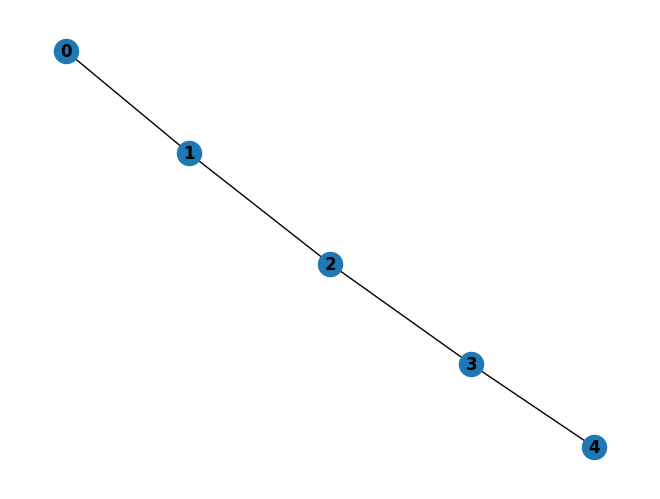

In [2]:
# let us define the graph
N = 5 # number of nodes
G = nx.path_graph(N)
# another graph
#G = nx.grid_2d_graph(2,3)
#G = nx.lollipop_graph(N-1,1)
# let us visualize it
nx.draw(G, with_labels=True, font_weight='bold')

In [3]:
A = nx.adjacency_matrix(G)
A.todense()

array([[0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0]])

We have a graph $G$ with $N$ nodes and adjacency matrix $A$.

What else do we need?

## The node features

We need to have information on the nodes: a vector of features $x_i\in \mathbb{R}^F$ at each node $i$. We gather the node information together in a matrix $X$ of size $N\times F$.


In [4]:
F = 6 # Number of features
X = np.zeros((N,F))
# Let us add some values
for idx in range(N):
  X[idx,idx] = 1
X[3,3:] = [1,1,1]
X[4,-1] = 1
X

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1.]])

## The Graph neural net
Neural nets are made of layers of neurons. Let us define a layer of Graph neural net.

We take the most standard architecture, introduced in [Kipf and Welling (2016)](https://arxiv.org/abs/1609.02907).
The basic Graph neural net Layer use the following matrices:
* $X$ matrix of node features (input)
* $W$ weight matrix (learnable)
* $\Delta$ matrix encoding the graph information (involving $A$)
* $Y$ output features after the NN layer

$$Y = \Delta XW$$
The GNN layer performs 2 *very different* operations on the input.
* Feature side: $W$ combines features for a new representation (new node embedding),
* Graph side: $\Delta$ aggregates features of connected nodes.

### The embeddings

In [5]:
# Let us create an initial weight matrix W
embed_size = 3 # choose an embedding size
W = np.ones((F,embed_size))
#W[3:,0] = [1,2,3]
W

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

Multiplying the input X with the weights W create the embeddings. The network learns to combine efficiently the features values at each node to solve the task. The entries of W are learnable and will change as the network train.

In [6]:
# Initial embeddings
Emb = X.dot(W)
Emb

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [3., 3., 3.],
       [2., 2., 2.]])

### The aggregation
We are now going to perform the second operation of a Graph neural net layer: node aggregation. Let us see what happens in the simple case where $\Delta = A$

In [7]:
# Let us recall what is A:
A.todense()

array([[0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0]])

In [8]:
# The aggregation operation
Agg = A@Emb
Agg

array([[1., 1., 1.],
       [2., 2., 2.],
       [4., 4., 4.],
       [3., 3., 3.],
       [3., 3., 3.]])

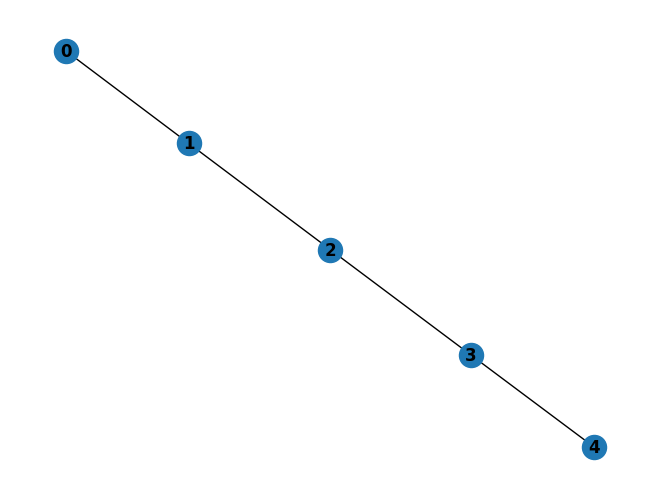

In [9]:
nx.draw(G, with_labels=True, font_weight='bold')

Applying $A$ sum the embeddings of the neighbor nodes!

**First remark:** To have a relevant representation, it may be useful to involve the embedding of the node itself in the aggregation! Solution: add self-edges (identity matrix)

In [10]:
B = A + np.eye(N)
B

array([[1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.]])

**Second remark:** All neighbors are treated equally in the agregation. It is actually one of the big problems with Graph neural Nets!

We can improve the agregation by reducing the influence of highly connected nodes. They are neighbors of many nodes, so they can have a lot of (bad) influence!

For that we will divide the contributions in the aggreagation by the node degrees, more precisely we introduce the matrix:
$$C = \sqrt{D^{-1}}B\sqrt{D^{-1}}
$$
The matrix $D$ is diagonal with strictly positive entries, so this operation is fine. **Note:** why we take the square root and apply on both side is motivated by maths. It is much more convenient to have a symmetric matrix (diagonalizable) to prove theorems with it :)  

In [11]:
# Degree matrix
degrees = np.sum(B,1)
D = np.diag(degrees)
# and the inverse, with the square root
Dsqinv = np.diag(np.sqrt(1/degrees))
Dsqinv

array([[0.70710678, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.57735027, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.57735027, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.70710678]])

In [12]:
# Our new aggregation matrix:
C = Dsqinv@B@Dsqinv
C

array([[0.5       , 0.40824829, 0.        , 0.        , 0.        ],
       [0.40824829, 0.33333333, 0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.33333333, 0.40824829],
       [0.        , 0.        , 0.        , 0.40824829, 0.5       ]])

The new aggregation is the multiplication with $C$ instead of $A$.

### the Graph neural net layer
Finally let us put everything together in a neural network layer

In [13]:
# function for the GNN layer
def GNNlayer(X,A,embed_size):
  N,F = X.shape
  W = np.random.rand(F,embed_size)
  B = A + np.eye(N)
  degrees = np.sum(B,1)
  Dsqinv = np.diag(np.sqrt(1/degrees))
  return Dsqinv@X@W

In [14]:
X2 = GNNlayer(X,A,5)

Voila!

## A full GNN
In a complete GNN, there are several layers and nonlinear functions in between

In [15]:
# A first layer
X2 = GNNlayer(X,A,5)
# A nonlinearity
X2n = np.tanh(X2)
# A second layer
X3 = GNNlayer(X2n,A,5)

In [16]:
X3

array([[0.87848157, 0.70507937, 0.66984771, 0.92286037, 0.75008101],
       [0.3159329 , 0.42052995, 0.38642695, 0.36195344, 0.34794162],
       [0.26817775, 0.22952873, 0.23122164, 0.37886179, 0.28512052],
       [1.34207602, 1.27643063, 1.2447832 , 1.36085485, 1.08560534],
       [1.54142798, 1.55800423, 1.49789024, 1.56406201, 1.21194148]])

We stop here. We don't cover the training of the GNN (updating the weight matrix $W$).

# Conclusion

Take home messages:
* Output of the GNN: one vector per node. *Remark:* to obtain one value per graph (e.g. molecules) you need an additional operation: Pooling.
* Aggregation depends only on the connections: 1) it is not learnable, 2) same action for any node (independent on the location in the graph)
* With many neighbors, aggregation average all values. It leads to the problem of oversmoothing.
* 1 layer aggregate over one-hop neighbors, with 2 layers each node can get information from 2-hop neighbors, and with $N$ layers, $N$ hops.  